# Machine Learning with TensorFlow in Vertex AI

TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries, and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

Vertex AI brings AutoML and AI Platform together into a unified API, client library, and user interface. With Vertex AI, both AutoML training and custom training are available options.

## Create minimal training and validation data

Import python libraries and set environment variables

In [1]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]
REGION = 'us-central1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:3]

Create the training dataset for model training

In [2]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'True'

Query complete after 0.01s: 100%|██████████| 4/4 [00:00<00:00, 1808.86query/s]                        


""


Create the evaluation dataset for model evaluation

In [3]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'False'

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1944.28query/s]                        


""


Create the full dataset

In [4]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 1679.06query/s]                        


""


Export the training, validation, and full datasets to CSV file format in the Google Cloud Storage bucket

In [5]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/data/train.csv and deleting table
Exporting dsongcp.flights_eval_data to gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/data/eval.csv and deleting table
Exporting dsongcp.flights_all_data to gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/data/all.csv and deleting table


Waiting on bqjob_r13b709c40bff4a5a_0000018143647d7e_1 ... (64s) Current status: DONE   
Waiting on bqjob_r357e4a8a982f784c_0000018143658996_1 ... (33s) Current status: DONE   
Waiting on bqjob_r49f07a39a7043713_0000018143661c2a_1 ... (85s) Current status: DONE   


In [6]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2022-06-08T13:00:59Z  gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/data/all.csv
115.19 MiB  2022-06-08T12:59:22Z  gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/data/eval.csv
296.96 MiB  2022-06-08T12:58:50Z  gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


## Create the input data

In [24]:
# For development purposes, train for a few epochs.
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000

In [8]:
# Assign training and validation data URI respectively.
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

In [9]:
# Set up Model Parameters
NBUCKETS = 5
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

### Reading data into TensorFlow

In [10]:
# To read the CSV files from Google Cloud Storage into TensorFlow
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()}
        print(n, numpy_data)
        if n==1: break

2022-06-08 13:02:03.906720: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-08 13:02:05.225403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


0 {'ontime': array([1, 0, 1, 1, 1], dtype=int32), 'dep_delay': array([ -4,  54,   6,  -2, -13], dtype=int32), 'taxi_out': array([12, 25, 12, 12, 14], dtype=int32), 'distance': array([253,  86, 511,  68, 650], dtype=int32), 'origin': array([b'ANC', b'HIB', b'OAK', b'STT', b'MYR'], dtype=object), 'dest': array([b'ADQ', b'INL', b'BOI', b'SJU', b'IAG'], dtype=object), 'dep_hour': array([23,  4,  2, 12, 14], dtype=int32), 'is_weekday': array([1, 1, 0, 1, 1], dtype=int32), 'carrier': array([b'AS', b'OO', b'WN', b'B6', b'NK'], dtype=object), 'dep_airport_lat': array([61.174168, 47.386665, 37.72278 , 18.337223, 33.67972 ],
      dtype=float32), 'dep_airport_lon': array([-149.99806 ,  -92.83889 , -122.22139 ,  -64.973335,  -78.92834 ],
      dtype=float32), 'arr_airport_lat': array([57.75    , 48.565556, 43.564445, 18.439444, 43.1075  ],
      dtype=float32), 'arr_airport_lon': array([-152.4939 ,  -93.40222, -116.22278,  -66.00222,  -78.94583],
      dtype=float32)}
1 {'ontime': array([0, 1, 1,

The `read_dataset()` function reads the training data, yielding batch_size examples each time, and stop iterating once a certain number of examples have been read.

The dataset contains all the columns in the CSV file, named according to the header line. The data consists of both features and the label. It's better to separate them by writing the `features_and_labels()` function to make the later code easier to read. 

In [11]:
def features_and_labels(features):
  label = features.pop('ontime') 
  return features, label
def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset
if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1, -2], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([6, 4], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([966,  31], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'PIT', b'WRG'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'RSW', b'PSG'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 18], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'WN', b'AS'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([40.49139 , 56.484444], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ -80.23278, -132.36972], dtype=float32)>), ('arr_a

## Create, train and evaluate TensorFlow model

Keras supports feature columns, opening up the ability to represent structured data using standard feature engineering techniques like embedding, bucketizing, and feature crosses. As numeric data can be passed in directly to the ML model, keep the real-valued columns separate from the sparse (or string) columns.

In [12]:
import tensorflow as tf
real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

All these features come directly from the input file that wants a prediction for a flight. Input layers map 1:1 to the input features and types, so rather than repeat the column names, create an input layer for each of these columns, specifying the right data type (either a float or a string).

In [13]:
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

**Bucketing**

Real-valued columns whose precision is overkill, thus likely to cause overfitting, can be discretized and made into categorical columns. Discretize the latitudes and longitudes and cross the buckets, results in breaking up the country into grids and yield the grid point into which a specific latitude and longitude falls.

In [14]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_airport_lon', 'arr_airport_lon']
})
# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)
# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)
# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}
if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


### Train and evaluate the model

In [15]:
# Save the checkpoint
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model


In [16]:
!gsutil -m rm -rf $OUTDIR

CommandException: 1 files/objects could not be removed.


With the sparse and real feature columns thus enhanced beyong the raw inputs, create a `wide_and_deep_classifier` passing in the linear and deep feature columns separately.

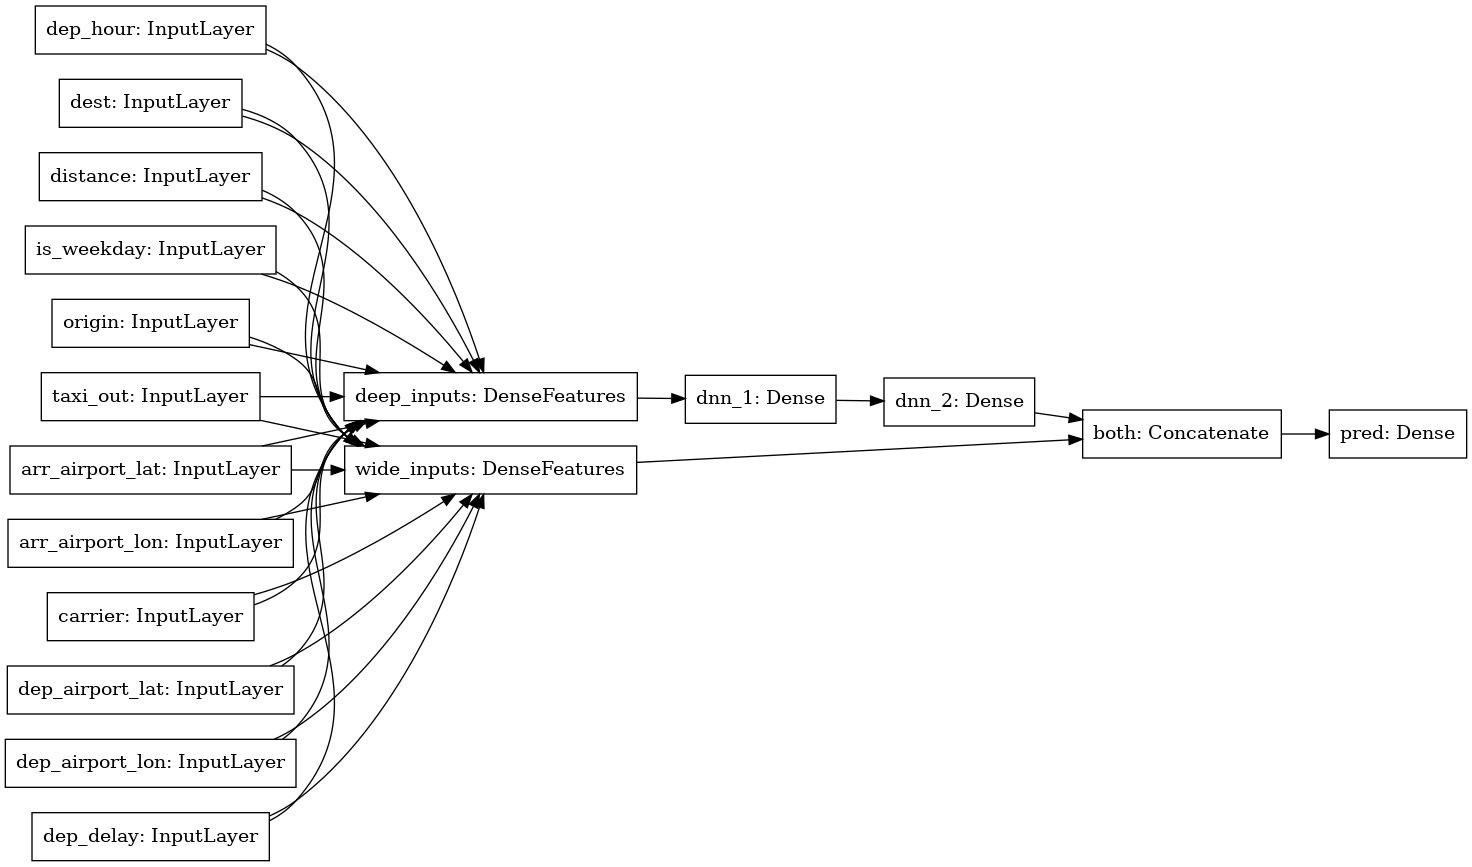

In [17]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

In [18]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)
checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
3/3 [==============================] - 15s 5s/step - loss: 7.8190 - accuracy: 0.1458 - val_loss: 3.1007 - val_accuracy: 0.1638

Epoch 00001: saving model to gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model/checkpoints/flights.cpt
Epoch 2/2
3/3 [==============================] - 9s 5s/step - loss: 1.7707 - accuracy: 0.3229 - val_loss: 0.6735 - val_accuracy: 0.7584

Epoch 00002: saving model to gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model/checkpoints/flights.cpt


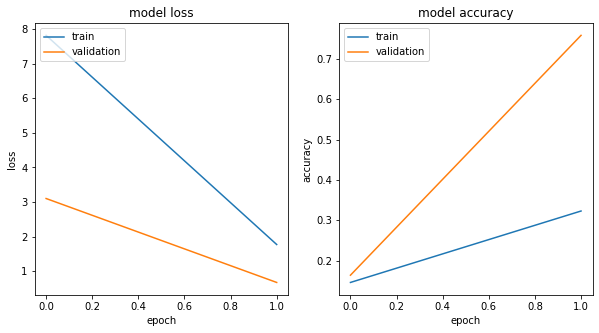

In [19]:
# Visualize the model loss and model accuracy
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))
for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

### Export the trained model

In [20]:
# Save the model artifacts to the Google Cloud Storage bucket.
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model/export/flights_20220608-130420


2022-06-08 13:04:23.038972: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model/export/flights_20220608-130420/assets


## Deploy flights model to Vertex AI

The models are containerized, dependency management is taken care of. The Endpoints take care of traffic splits, allowing A/B testing in a convenient way. Create the model endpoint.

In [23]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"
# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done
# create the model using the parameters docker conatiner image and artifact uri
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"
# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model/export/flights_20220608-130420/
Endpoint for flights-20220608-130803 already exists
ENDPOINT_ID=6134351293222748160
MODEL_ID=1785523320624513024


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2950602743774969856]...
...................done.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [9120534233272549376]...
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Create a test input file.

In [25]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Writing example_input.json


Make a prediction from the model endpoint.

In [26]:
%%bash
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

6134351293222748160
[[0.452970862], [0.443386793]]


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


Send an HTTP POST request and get the result back as JSON

In [27]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

{
  "predictions": [
    [
      0.452970862
    ],
    [
      0.443386793
    ]
  ],
  "deployedModelId": "689618090987618304",
  "model": "projects/345280200847/locations/us-central1/models/1785523320624513024",
  "modelDisplayName": "flights-20220608-130803"
}


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   808    0   265  100   543   4274   8758 --:--:-- --:--:-- --:--:-- 13032


## Model Explainability

Model explainability is one fo the most important problems in machine learning. It's a broad concept of analyzing and understanding the results provided by machine learning models. Explainability in machine learning means explain what happens in model from input to output. Explainable AI (XAI) makes models transparent and solves the black box problem.

In [28]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model/export/flights_20220608-130420/
The given SavedModel SignatureDef contains the following input(s):
  inputs['arr_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lat:0
  inputs['arr_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lon:0
  inputs['carrier'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_carrier:0
  inputs['dep_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lat:0
  inputs['dep_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lon:0
  inputs['dep_delay'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_delay:0
  inputs['dep_hour'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_

In [29]:
# Create a JSON file that contains the metadata describing the Model's input and output 
# for explanation.
cols = ('dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
        'dep_airport_lat,dep_airport_lon,' +
        'arr_airport_lat,arr_airport_lon,' +
        'carrier,origin,dest')
inputs = {x: {"inputTensorName": "{}".format(x)} 
        for x in cols.split(',')}
expl = {
    "inputs": inputs,
    "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}
print(expl)
with open('explanation-metadata.json', 'w') as ofp:
    json.dump(expl, ofp, indent=2)

{'inputs': {'dep_delay': {'inputTensorName': 'dep_delay'}, 'taxi_out': {'inputTensorName': 'taxi_out'}, 'distance': {'inputTensorName': 'distance'}, 'dep_hour': {'inputTensorName': 'dep_hour'}, 'is_weekday': {'inputTensorName': 'is_weekday'}, 'dep_airport_lat': {'inputTensorName': 'dep_airport_lat'}, 'dep_airport_lon': {'inputTensorName': 'dep_airport_lon'}, 'arr_airport_lat': {'inputTensorName': 'arr_airport_lat'}, 'arr_airport_lon': {'inputTensorName': 'arr_airport_lon'}, 'carrier': {'inputTensorName': 'carrier'}, 'origin': {'inputTensorName': 'origin'}, 'dest': {'inputTensorName': 'dest'}}, 'outputs': {'pred': {'outputTensorName': 'pred'}}}


In [30]:
!cat explanation-metadata.json

{
  "inputs": {
    "dep_delay": {
      "inputTensorName": "dep_delay"
    },
    "taxi_out": {
      "inputTensorName": "taxi_out"
    },
    "distance": {
      "inputTensorName": "distance"
    },
    "dep_hour": {
      "inputTensorName": "dep_hour"
    },
    "is_weekday": {
      "inputTensorName": "is_weekday"
    },
    "dep_airport_lat": {
      "inputTensorName": "dep_airport_lat"
    },
    "dep_airport_lon": {
      "inputTensorName": "dep_airport_lon"
    },
    "arr_airport_lat": {
      "inputTensorName": "arr_airport_lat"
    },
    "arr_airport_lon": {
      "inputTensorName": "arr_airport_lon"
    },
    "carrier": {
      "inputTensorName": "carrier"
    },
    "origin": {
      "inputTensorName": "origin"
    },
    "dest": {
      "inputTensorName": "dest"
    }
  },
  "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}

## Invoke the deployed model

Create the model endpoint `flights_xai`, upload the model, and deploy it at the model endpoint. Client programs have the input data in a JSON file, send an HTTP POST request and get the result back as JSON.

In [31]:
%%bash
# note TF_VERSION set in 1st cell, but ENDPOINT_NAME is being changed
# TF_VERSION=2-6
ENDPOINT_NAME=flights_xai
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"
# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done
# upload the model using the parameters docker conatiner image, artifact URI, explanation method, 
# explanation path count and explanation metadata JSON file `explanation-metadata.json`. 
# Here, you keep number of feature permutations to `10` when approximating the Shapley values for explanation.
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH \
     --explanation-method=sampled-shapley --explanation-path-count=10 --explanation-metadata-file=explanation-metadata.json
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"
# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-01-7487023a646a-dsongcp/ch9/trained_model/export/flights_20220608-130420/
Creating Endpoint for flights_xai-20220608-133143
ENDPOINT_ID=2621543583873761280
MODEL_ID=6397209339051900928


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [3083458932782399488]...
.................done.
Created Vertex AI endpoint: projects/345280200847/locations/us-central1/endpoints/2621543583873761280.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2019483520816119808]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [33]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_NAME=flights_xai
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:explain"

{
  "explanations": [
    {
      "attributions": [
        {
          "baselineOutputValue": 0.50521302223205566,
          "instanceOutputValue": 0.45297086238861084,
          "featureAttributions": {
            "dep_delay": -0.055733987689018251,
            "distance": 0.023588821291923519,
            "is_weekday": 0.0012238711118698121,
            "arr_airport_lat": -0.030807504057884221,
            "dep_airport_lat": 0.076913017034530642,
            "carrier": -0.0034830391407012942,
            "arr_airport_lon": 0.17322605550289161,
            "taxi_out": -0.016305908560752869,
            "dep_airport_lon": -0.2097671985626221,
            "dep_hour": -0.0012684196233749389,
            "origin": -0.0026994049549102779,
            "dest": -0.0071284621953964233
          },
          "outputIndex": [
            0
          ],
          "approximationError": 0.010057138835580457,
          "outputName": "pred"
        }
      ]
    },
    {
      "attributions": [
   

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2566    0  2023  100   543  11365   3050 --:--:-- --:--:-- --:--:-- 14415
